# Enviroment

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import glob
import os
import os.path as osp
import torch
import shutil
import warnings
import optuna
import torch
import torch.optim as optim
from IPython.display import display, clear_output
from torch_geometric.data import Data
from torch_geometric.io import read_txt_array
from torch_geometric.utils import coalesce, remove_self_loops
from torch_geometric.utils import to_undirected, is_undirected, to_networkx
from types import SimpleNamespace
from tqdm import tqdm
from logparser.Drain import LogParser

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix
)


warnings.filterwarnings("ignore")

from DataLoader import create_loaders, MeanTrainer, GIN, DiGCN, DiGCN_IB_Sum
from GetAdjacencyMatrix import get_undirected_adj,get_pr_directed_adj,get_appr_directed_adj,get_second_directed_adj, get_appr_directed_adj_keep_attr

root_path = r'/home/ubuntu/bsc/BootDet/Log2Graph'

# Embeddings

In [28]:
import re
import json
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.feature_extraction.text import TfidfVectorizer

# ---------------------------------------------------
# 1) Load CSV templates
# ---------------------------------------------------
csv_path = f'{root_path}/Data/BSC/BSC.log_templates.csv'
df = pd.read_csv(csv_path, )
texts = df['EventTemplate'].dropna().astype(str).tolist()

print(f"Loaded {len(texts)} templates from {csv_path}")

# ---------------------------------------------------
# 2) Load GloVe 200-D vectors
# ---------------------------------------------------
# glove_input_file = "/home/ubuntu/bsc/BootDet/Log2Graph/MyData/glove.6B.200d.txt"
# word2vec_output_file = "glove.6B.200d.w2v.txt"
glove_input_file = "/home/ubuntu/bsc/BootDet/Log2Graph/MyData/glove.6B.50d.txt"
word2vec_output_file = "glove.6B.50d.w2v.txt"

# Convert only once
glove2word2vec(glove_input_file, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
print("Loaded GloVe embeddings (200D).")

# ---------------------------------------------------
# 3) TF-IDF setup
# ---------------------------------------------------
def tokenize(text):
    # Keep words only (drop <*> etc.)
    return [t.lower() for t in re.findall(r"\w+", text)]

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=None,
    lowercase=False,
    token_pattern=None
)
tfidf_matrix = vectorizer.fit_transform(texts)
vocab = vectorizer.vocabulary_
rev_vocab = {v: k for k, v in vocab.items()}
print("TF-IDF model fitted on all templates.")

# ---------------------------------------------------
# 4) TF-IDF weighted GloVe embedding
# ---------------------------------------------------
def tfidf_glove_vector(text: str) -> np.ndarray:
    vec = np.zeros(model.vector_size, dtype=np.float32)
    weights_sum = 0.0

    tfidf_vec = vectorizer.transform([text]).tocoo()
    for idx, weight in zip(tfidf_vec.col, tfidf_vec.data):
        token = rev_vocab[idx]
        if token in model:
            vec += weight * model[token]
            weights_sum += weight

    if weights_sum > 0:
        vec /= weights_sum
    return vec

# ---------------------------------------------------
# 5) Compute embeddings and export JSON
# ---------------------------------------------------
def vector_to_json(vec: np.ndarray):
    return {str(i): float(v) for i, v in enumerate(vec)}

result = {}
for text in texts:
    result[text] = vector_to_json(tfidf_glove_vector(text))

output_path = f"{root_path}/Data/Gloves/Results/embeddings.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

print(f"✅ Saved embeddings for {len(texts)} templates to {output_path}")


Loaded 66 templates from /home/ubuntu/bsc/BootDet/Log2Graph/supervised/Data/BSC/BSC.log_templates.csv
Loaded GloVe embeddings (200D).
TF-IDF model fitted on all templates.
✅ Saved embeddings for 66 templates to /home/ubuntu/bsc/BootDet/Log2Graph/supervised/Data/Gloves/Results/embeddings.json


# GraphGeneration

In [30]:
"""
Created on Fri Dec 16 14:31:09 2022

Generate attributed, directed and edge-weighted graphs from logs, 
and convert them into TUDataset format (but with directed version)
"""
# =============================================================================
# PreStep 1: Load parsered dataset BSC
# =============================================================================

MyDataName = "BSC"

df = pd.read_csv(root_path + '/Data/BSC/BSC.log_structured.csv', sep=',')

raw_df = df[["LineId","EventId", "EventTemplate", "GroupId"]] 
# raw_df["GroupId"] = df[['BootId']].astype(str)


# =============================================================================
# PreStep 2: Load semantic embedding vector of all log event templates
# =============================================================================

##load embedding vec from a jason file
with open(root_path + '/Data/Gloves/Results/embeddings.json', 'r') as fp:
    embedding_dict = json.load(fp)
    
embedding_df = pd.DataFrame.from_dict(embedding_dict)


# =============================================================================
# Step 1. for each group of log messages, define a function to construct a raw graph 
#         that contains all information: node, edges, node attributes, edge attributes
# =============================================================================

def GraphConstruction(my_example_df, graph_count_index, graph_loc_index, my_node_accum, new_node_accum):
    # =============================================================================
    # #write a function to generate a graph from each group of log events and store them as
    # 1. BSC_A.txt
    # 2. BSC_edge_attributes.txt
    # 3. BSC_graph_indicator.txt
    # 4. BSC_graph_labels.txt
    # 5. BSC_node_attributes.txt
    # =============================================================================

    G = nx.MultiDiGraph()
    event_list = list(my_example_df["EventTemplate"])
    node_list = list(dict.fromkeys(event_list))
    G.add_nodes_from(node_list)
    G.add_edges_from([(event_list[v],event_list[v+1]) for v in range(len(event_list)-1)])
    
    # nx.draw(G, with_labels = True)

    ##get adjacency matrix in the form of sparse matrix
    A = nx.adjacency_matrix(G)
    
    # =============================================================================
    # 1. Adj Matrix: done, by handling it with get_adj in DIGCN
    # =============================================================================
    df_A = pd.DataFrame(columns=["row","column"])
    row_vec = (list(A.nonzero())[0]).tolist()
    col_vec = (list(A.nonzero())[1]).tolist()
    # row_vec = [a+my_node_accum for a in row_vec]
    # col_vec = [a+my_node_accum for a in col_vec]
    row_vec = [a+1 for a in row_vec]
    col_vec = [a+1 for a in col_vec]
    df_A["row"] = row_vec
    df_A["column"] = col_vec
    
    # print("\n-----df_A in GraphConstruction()-------")
    # print(df_A)
    
    fp_A = root_path + "/Data/BSC/Graph/TempRaw/" + MyDataName + "_A.txt"
    np.savetxt(fp_A, df_A.values, fmt='%i', delimiter=', ')

               
    # =============================================================================
    # 2. Edge-weight Matrix: done
    # =============================================================================
    df_edge_weight = pd.DataFrame(columns=["edge_weight"])
    df_edge_weight["edge_weight"] = list(A.data)
    fp_edge_weight = root_path + "/Data/BSC/Graph/TempRaw/" + MyDataName + "_edge_attributes.txt"
    np.savetxt(fp_edge_weight, df_edge_weight.values, fmt='%i', delimiter=', ')
    
    
    # =============================================================================
    # 3. Graph-indicator Matrix: done
    # =============================================================================
    df_graph_indicator = pd.DataFrame(columns=["indicator"])
    df_graph_indicator["indicator"] = [graph_count_index+1]*len(new_node_accum)
    fp_graph_indicator = root_path + "/Data/BSC/Graph/TempRaw/" + MyDataName + "_graph_indicator.txt"
    np.savetxt(fp_graph_indicator, df_graph_indicator.values, fmt='%i', delimiter=', ')  
    
    
    # =============================================================================
    # 4. Graph-labels Matrix: done, by modifing the train/test split code in GLAM 
    # =============================================================================
    ##use the anomaly_label.csv file to generate this matrix
    df_label = pd.read_csv(root_path + '/Data/BSC/anomaly_label.csv', sep=',')
    di_replace = {"Normal": 0, "Anomaly": 1}
    df_label = df_label.replace({"Label": di_replace})
    label_value = df_label.iloc[graph_loc_index]['Label']
    # print("\n------label------")
    # print(label_value)
    
    df_graph_labels = pd.DataFrame(columns=["labels"])
    # df_graph_labels["labels"] = [label_value]*len(list(A.data))
    df_graph_labels["labels"] = [label_value]
    fp_graph_labels = root_path + "/Data/BSC/Graph/TempRaw/" + MyDataName + "_graph_labels.txt"
    np.savetxt(fp_graph_labels, df_graph_labels.values, fmt='%i', delimiter=', ') 
    
    
    # =============================================================================
    # 5. Node-attributes Matrix: by retrieving semantic embedding vec from embedding_df dataframe
    # =============================================================================
    
    node_attr_list = []
    mylist = event_list ## mylist = list(my_example_df["EventTemplate"])   
    
    print("-------------------------------------------------------------------")
    for node_name in list(dict.fromkeys(mylist)):   ##this is important, we must keep the order of nodes
        print("----++++++++++++++++++++++------")
        print(node_name)
    
        arr_vec = embedding_df[node_name].values.tolist()
        
        node_attr_list.append(arr_vec) 
    
    print("-------------------------------------------------------------------")
        
    df_node_attributes = pd.DataFrame(node_attr_list)
                
    fp_node_attributes = root_path + "/Data/BSC/Graph/TempRaw/" + MyDataName + "_node_attributes.txt"
    np.savetxt(fp_node_attributes, df_node_attributes.values,fmt='%f', delimiter=', ') 


# =============================================================================
# Step 2. for each raw graph, we use the theory from DiGCN paper to generate new graph
#         that contains more information: k-neighbours (2 in our usecase)
# =============================================================================

def read_file(folder, prefix, name, dtype=None):
    path = osp.join(folder, f'{prefix}_{name}.txt')
    return read_txt_array(path, sep=',', dtype=dtype)


def cat(seq):
    seq = [item for item in seq if item is not None]
    seq = [item for item in seq if item.numel() > 0]
    seq = [item.unsqueeze(-1) if item.dim() == 1 else item for item in seq]
    return torch.cat(seq, dim=-1) if len(seq) > 0 else None


def read_tu_data(folder, prefix, adj_type):
    
    # =============================================================================
    # read edge index from adj matrix
    # =============================================================================
    edge_index = read_file(folder, prefix, 'A', torch.long).t() - 1 
    
    # print("\n-----edge_index in read_tu_data()-------")
    # print(edge_index)
    
    # =============================================================================
    # read graph index
    # =============================================================================    
    batch = read_file(folder, prefix, 'graph_indicator', torch.long) - 1

    # =============================================================================
    # read node attributes
    # =============================================================================
    
    if batch.dim() == 0: ## the batch looks like ->tensor(42), which is zero dimension
        node_attributes = torch.empty((1, 0))
        
    else: ## the batch looks like ->tensor([41, 41, 41, 41, 41, 41]), which is one dimension
        node_attributes = torch.empty((batch.size(0), 0))
    node_attributes = read_file(folder, prefix, 'node_attributes')
    if node_attributes.dim() == 1:
        node_attributes = node_attributes.unsqueeze(-1)

    # =============================================================================
    # read edge attributes
    # =============================================================================
    # print("edge_index.shape")
    # print(edge_index.shape)
    
    is_empty_index = 0
    
    if len(edge_index.shape) == 1:##some graph only have a single row
        
        is_empty_index = 1
        data = Data()
        print("---we have empty graph here---")
        return data,is_empty_index  ##if it is empty, we skip this dataset
    
        if edge_index.shape[0] == 0:
          
            ##if it is empty, which means one node without any edges, we build a self-loop edge
            edge_index = torch.tensor([[1],[1]])
            
            is_empty_index = 1
            data = Data()
            print("---we have empty graph here---")
            return data,is_empty_index  ##if it is empty, we skip this dataset            
        else:           
            ##if this row is not empty, which mean two node with one edge
            edge_index = torch.tensor([[edge_index[0].item()],[edge_index[1].item()]])
        
    
    ##some graphs only have a single node, we should skip those graphs?
    
    edge_attributes = torch.empty((edge_index.size(1), 0))
    edge_attributes = read_file(folder, prefix, 'edge_attributes')
    
    # print(edge_attributes)
    
    if edge_attributes.dim() == 1:
        edge_attributes = edge_attributes.unsqueeze(-1)


    # =============================================================================
    # concategate node attributes
    # =============================================================================
    # print("---------node-cat---------------")
    x = cat([node_attributes])
    
    # print("-----x.size(0)------")
    # print(x.size(0))
    
    # =============================================================================
    # concategate edge attributes and edge lables
    # =============================================================================
    # edge_attr = cat([edge_attributes, edge_labels])
    # print("---------edge-cat---------------")
    
    if edge_index.size(1) == 1: ##some graph only have a single row, this causes tensor with 0 dimension
        
        edge_attr = torch.tensor([[edge_attributes.item()]])
        
        # ##if it is empty, which means one node without any edges, we build a self-loop edge
        # if is_empty_index == 1:
            
        #     edge_attr = torch.tensor([[1]])
            
        # ##if this row is not empty, which mean two node with one edge
        # else:
        #     edge_attr = torch.tensor([[edge_attributes.item()]])
        
    else:       
        edge_attr = cat([edge_attributes])
        

    # =============================================================================
    # read graph attributes or graph labels
    # =============================================================================
    y = None
    y = read_file(folder, prefix, 'graph_labels', torch.long)

    # =============================================================================
    # get total number of nodes for all graphs
    # =============================================================================
    num_nodes = edge_index.max().item() + 1 if x is None else x.size(0)

    # =============================================================================
    # remove self-loops: we should not remove selfloops
    # =============================================================================    
    # edge_index, edge_attr = remove_self_loops(edge_index, edge_attr) 
    
    if edge_attr is None:
        edge_index = coalesce(edge_index, num_nodes=num_nodes)
    else:
        edge_index, edge_attr = coalesce(edge_index, edge_attr, num_nodes)
        
        
    # =============================================================================
    # use get_adj to preprocess data: we should do this for each graph saparately
    # =============================================================================  
    
    # adj_type = 'appr'
    if adj_type == 'un':    
        print("\n Processing to undirected adj")
        indices = edge_index
        features = x
        indices = to_undirected(indices)
        
        edge_index, edge_attr = get_undirected_adj(edge_index = indices,
                                                   num_nodes = features.shape[0],
                                                   dtype = features.dtype)
        
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        
    elif adj_type == 'appr':
        print("\n Processing approximate personalized pagerank adj matrix")
        alpha = 0.1
        indices = edge_index
        features = x
        
        edge_index, edge_attr = get_appr_directed_adj(alpha = alpha, 
                                                      edge_index = indices, 
                                                      num_nodes = features.shape[0],
                                                      dtype = features.dtype,
                                                      edge_weight = edge_attr)
        
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
         
    elif adj_type == 'ib':
        print("\n Processing first and second-order adj matrix")
        alpha = 0.1
        indices = edge_index
        features = x
                
        # edge_index, edge_attr = get_appr_directed_adj_keep_attr(alpha = alpha, 
        #                                                         edge_index = indices, 
        #                                                         num_nodes = features.shape[0],
        #                                                         dtype = features.dtype,
        #                                                         edge_weight = edge_attr) 
        
 
        edge_index, edge_attr = get_appr_directed_adj(alpha = alpha, 
                                                      edge_index = indices, 
                                                      num_nodes = features.shape[0],
                                                      dtype = features.dtype,
                                                      edge_weight = edge_attr)
        
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        
        ##we should input approximate edge_index, edge_attr or the original edge_index, edge_attr?
        
        # edge_index2, edge_attr2 = get_second_directed_adj(edge_index = indices, 
        #                                                   num_nodes = features.shape[0],
        #                                                   dtype = features.dtype,
        #                                                   edge_weight = edge_attr)
        
        edge_index2, edge_attr2 = get_second_directed_adj(edge_index = edge_index, 
                                                          num_nodes = features.shape[0],
                                                          dtype = features.dtype,
                                                          edge_weight = edge_attr)
    
        data.edge_index2 = edge_index2
        data.edge_attr2 = edge_attr2

    return data, is_empty_index


# =============================================================================
# Step 3. define a function to concatenate all dervied individual graphs
# =============================================================================

def ConcatGraphs(ReadGraph, graph_count_index, my_node_accum, new_node_accum, adj_type):
    # =============================================================================
    # #write a function to concatenate appr graphs
    # 1. BSC_A.txt
    # 2. BSC_edge_attributes.txt
    # 3. BSC_graph_indicator.txt
    # 4. BSC_graph_labels.txt
    # 5. BSC_node_attributes.txt
    # =============================================================================
    import pandas as pd
    import numpy as np
    
    # =============================================================================
    # 1. Adj Matrix
    # =============================================================================
    fp_A = root_path + "/Data/BSC/Graph/Raw/" + MyDataName + "_A.txt"
    df_A = pd.DataFrame(ReadGraph.edge_index.numpy()).T
    df_A = df_A  + my_node_accum
    # print("\n-----df_A in ConcatGraphs()-------")
    # print(df_A)
    with open(fp_A, "ab") as f:
        np.savetxt(f, df_A.values, fmt='%i', delimiter=', ')
               
    # =============================================================================
    # 2. Edge-weight Matrix
    # =============================================================================
    fp_edge_weight = root_path + "/Data/BSC/Graph/Raw/" + MyDataName + "_edge_attributes.txt"
    df_edge_weight = pd.DataFrame(ReadGraph.edge_attr.numpy())
    with open(fp_edge_weight, "ab") as f:
        np.savetxt(f, df_edge_weight.values, fmt='%f', delimiter=', ')
        
    
    # =============================================================================
    # 3. Graph-indicator Matrix
    # =============================================================================
    df_graph_indicator = pd.DataFrame(columns=["indicator"])    
    df_graph_indicator["indicator"] = [graph_count_index+1]*len(new_node_accum)
    fp_graph_indicator = root_path + "/Data/BSC/Graph/Raw/" + MyDataName + "_graph_indicator.txt"
    with open(fp_graph_indicator, "ab") as f:
        np.savetxt(f, df_graph_indicator.values, fmt='%i', delimiter=', ')  
    
    
    # =============================================================================
    # 4. Graph-labels Matrix
    # =============================================================================
    ##use the anomaly_label.csv file to generate this matrix
    
    fp_graph_labels = root_path + "/Data/BSC/Graph/Raw/" + MyDataName + "_graph_labels.txt"
    df_graph_labels = pd.DataFrame([ReadGraph.y.numpy()])
    with open(fp_graph_labels, "ab") as f: 
        np.savetxt(f, df_graph_labels.values, fmt='%i', delimiter=', ') 
    
    
    # =============================================================================
    # 5. Node-attributes Matrix
    # =============================================================================

    fp_node_attributes = root_path + "/Data/BSC/Graph/Raw/" + MyDataName + "_node_attributes.txt"
    
    df_node_attributes = pd.DataFrame(ReadGraph.x.numpy())
    
    with open(fp_node_attributes, "ab") as f: 
        np.savetxt(f, df_node_attributes.values,fmt='%f', delimiter=', ') 
        
    if adj_type == 'ib':
        
        # =============================================================================
        # 6. Second-order Adj Matrix
        # =============================================================================
        fp_A2 = root_path + "/Data/BSC/Graph/Raw/" + MyDataName + "_A2.txt"
        df_A2 = pd.DataFrame(ReadGraph.edge_index2.numpy()).T
        df_A2 = df_A2  + my_node_accum
        with open(fp_A2, "ab") as f:
            np.savetxt(f, df_A2.values, fmt='%i', delimiter=', ')
                   
        # =============================================================================
        # 7. Second-order Edge-weight Matrix
        # =============================================================================
        fp_edge_weight2 = root_path + "/Data/BSC/Graph/Raw/" + MyDataName + "_edge_attributes2.txt"
        df_edge_weight2 = pd.DataFrame(ReadGraph.edge_attr2.numpy())
        with open(fp_edge_weight2, "ab") as f:
            np.savetxt(f, df_edge_weight2.values, fmt='%f', delimiter=', ')
        


# =============================================================================
# Step4. Run the experiments
# =============================================================================


##--------------------------------------------
##Step 4.1. first clear all files under the /Raw/~ directory
##--------------------------------------------

folder = root_path + '/Data/BSC/Graph/Raw'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
        
        
        
   
##--------------------------------------------
##Step 4.2. run experiments
##--------------------------------------------
all_event_df = pd.read_csv(root_path + '/Data/BSC/anomaly_label.csv', sep=',')

group_to_check = list(all_event_df["BlockId"])

# list_group = group_to_check[0:1000]


##define a function to draw samples randomly but control the proportion
def draw_sample(num_samples, anomaly_per, draw_code):
    if draw_code == 1:     
        ##we should write a function to draw graphs which ensures that anomalies are only a small part
        anomaly_index_list = all_event_df.index[all_event_df['Label'] == "Anomaly"].tolist()
        normal_index_list = all_event_df.index[all_event_df['Label'] == "Normal"].tolist()
        
        import random
        random.seed(0)
        # random.seed(10) ##we change the random seed here
        # random.seed(20) 
        # random.seed(30) 
        # random.seed(40) 
        # random.seed(50) 

        
        anomal_drawn = random.sample(anomaly_index_list, int(num_samples*anomaly_per))
        normal_drawn = random.sample(normal_index_list, int(num_samples*(1-anomaly_per)))
        sample_drawn = anomal_drawn + normal_drawn
        list_group = [group_to_check[my_idx] for my_idx in sample_drawn]
        
        return list_group, sample_drawn
    else:
        ##we should write a function to draw graphs which ensures that anomalies are only a small part
        anomaly_index_list = all_event_df.index[all_event_df['Label'] == "Anomaly"].tolist()
        normal_index_list = all_event_df.index[all_event_df['Label'] == "Normal"].tolist()
        
        all_samples = anomaly_index_list + normal_index_list
        list_group = [group_to_check[my_idx] for my_idx in all_samples]
        
        return list_group, all_samples


num_graphs_to_test = 210
anomaly_perentage = 16/210
draw_code_val = 1
list_group, list_group_idx = draw_sample(num_graphs_to_test, anomaly_perentage,draw_code_val)


all_event_list = []
count_index = 0

graph_id_mapping = []

for group_name in tqdm(list_group):
    clear_output(wait=True)
    example_df = raw_df[raw_df["GroupId"] == group_name]
    node_accum = max(len(all_event_list)+1,1)
    new_event_list = list(dict.fromkeys(example_df["EventTemplate"]))
    
    ##GraphConstruction(): construct a graph for each group of logs
    GraphConstruction(my_example_df = example_df,
                      graph_count_index = count_index,
                      graph_loc_index = list_group_idx[count_index],
                      my_node_accum = node_accum,
                      new_node_accum = new_event_list)
    
    ##after generating each graph, we get its appr adj matrix accordingly
    MyReadGraph,empty_index = read_tu_data(folder = root_path + "/Data/BSC/Graph/TempRaw",
                                           prefix = MyDataName,
                                           adj_type = 'ib')
    
    if empty_index == 0: 
        ##oncatenate all appr graphs (only none-empty graphs)
        ConcatGraphs(ReadGraph = MyReadGraph,
                     graph_count_index = count_index,
                     my_node_accum = node_accum,
                     new_node_accum = new_event_list,
                     adj_type = 'ib')
        
        graph_id_mapping.append({
            "GraphIndex": count_index,
            "GroupId": group_name
        })
        
        all_event_list += new_event_list
        count_index += 1
    
all_event_list = list(dict.fromkeys(all_event_list))  

# Zapisz mapowanie GraphIndex -> GroupId (BootId)
graph_ids_path = root_path + "/Data/BSC/graph_ids.csv"
df_map = pd.DataFrame(graph_id_mapping)
df_map.to_csv(graph_ids_path, index=False)
print(f"Saved GraphIndex → GroupId mapping to {graph_ids_path}")
  




-------------------------------------------------------------------
----++++++++++++++++++++++------
The operating system started at system time <*>
----++++++++++++++++++++++------
The system time was initialized to <*> Loader time: <*> Internal boot flags: <*> HAL RTC error code: <*> RTC time is in UTC: false Soft boot: false Success: true Phase<*>
----++++++++++++++++++++++------
Virtualization-based security (policies<*>) is disabled.
----++++++++++++++++++++++------
The last shutdown's success status was true. The last boot's success status was true.
----++++++++++++++++++++++------
Unable to load Pluton-Windows firmware. StatusCode: STATUS_SUCCESS, Reason: Failed to apply firmware.
----++++++++++++++++++++++------
EFI time zone bias<*>. Daylight flags<*>. Firmware time: <*>
----++++++++++++++++++++++------
The boot type was <*>.
----++++++++++++++++++++++------
The boot menu policy was <*>.
----++++++++++++++++++++++------
There are <*> boot options on this system.
----++++++++++

100%|██████████| 210/210 [00:06<00:00, 33.57it/s]


 Processing first and second-order adj matrix
Saved GraphIndex → GroupId mapping to /home/ubuntu/bsc/BootDet/Log2Graph/supervised/Data/BSC/graph_ids.csv


# Main

In [9]:
"""
#Repurposed from the GLAM paper https://github.com/sawlani/GLAM
#Date: 01 Jan 2023
df['GroupId'] = df['ParameterList'].str.extract('(blk\_[-]?\d+)', expand=False)

"""
##--------------------------------------------
##Step 1. first clear all files under the /processed/~ directory
##--------------------------------------------


folder = root_path + '/Data/BSC/processed'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
        

folder = root_path + '/Data/BSC/Raw'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
        
##--------------------------------------------
##Step 2. copy all files from a directory to another
##--------------------------------------------       
 
# path to source directory
src_dir = root_path + '/Data/BSC/Graph/Raw/'
 
# path to destination directory
dest_dir = root_path + '/Data/BSC/Raw/'
 
# getting all the files in the source directory
my_files = os.listdir(src_dir)
 
for file_name in my_files:
    print(file_name)
    print(type(dest_dir))
    src_file_name = src_dir + file_name
    dest_file_name = dest_dir + file_name
    shutil.copy(src_file_name, dest_file_name)
     
    
        
##--------------------------------------------
##Step 3. define a function to run experiments
##--------------------------------------------          
        
def run_experiment(
    data = "BSC", #data_name to use
    data_seed=1213, 
    alpha=1.0, 
    beta=0.0,
    epochs=150, 
    model_seed=0, 
    num_layers=1, 
    device=0,
    aggregation="Mean",
    bias=False,
    hidden_dim=64,
    lr=0.1,
    weight_decay=1e-5,
    batch = 64
    ):

    device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")
    
    # =============================================================================
    # Step1. load data using predefined script dataloader.py
    # we should define this function by ourself
    # =============================================================================
    
    train_loader, eval_loader, val_loader, test_loader, num_features, train_dataset, val_dataset, test_dataset, raw_dataset = create_loaders(data_name=data,
                                                                                                                  batch_size=batch,
                                                                                                                  dense=False,
                                                                                                                  data_seed=data_seed)

    
    ##----set seeds for cuda----
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
        
    # =============================================================================
    # Step2. train a GIN model with given parameters
    # =============================================================================
    
    ##----setting paramters----

    model = DiGCN(nfeat = num_features, nhid=hidden_dim, nlayer=num_layers, bias=bias)
    

    ##----important paramter 0----##
    ##the learning rate, weight decay hyperparameter are given here
    ##In GLAM they use SGD, however, we will use Adam in our paper
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay) 
    
    if aggregation=="Mean":
        trainer = MeanTrainer(
            model=model,
            optimizer=optimizer,
            alpha=alpha,
            beta=beta,
            device=device
            )
    
    epochinfo = []

    for epoch in range(epochs+1):
        # print(f"\n===== Epoch {epoch} =====")

        train_loss = trainer.train(train_loader)
        val_loss   = trainer.validate(val_loader)

        # print(f"Train loss: {train_loss:.6f}")
        # print(f"Val   loss: {val_loss:.6f}")

        ap, roc_auc, dists, labels = trainer.test(test_loader=eval_loader)
        # print(f"ROC-AUC: {roc_auc:.3f}, AP: {ap:.3f}")

        TEMP = SimpleNamespace()
        TEMP.epoch_no   = epoch
        TEMP.train_loss = train_loss
        TEMP.val_loss   = val_loss
        TEMP.ap         = ap
        TEMP.roc_auc    = roc_auc
        TEMP.dists      = dists
        TEMP.labels     = labels
        epochinfo.append(TEMP)
        


    final_ap, final_roc_auc, final_dists, final_labels = trainer.test(test_loader=test_loader)
    best_idx = np.argmin([e.val_loss for e in epochinfo[1:]]) + 1
    best = epochinfo[best_idx]

    # print(f"\nBest epoch (by val_loss): {best.epoch_no}")
    # print(f"  train_loss = {best.train_loss:.6f}")
    # print(f"  val_loss   = {best.val_loss:.6f}")
    # print(f"  ROC-AUC    = {best.roc_auc:.3f}, AP = {best.ap:.3f}")
    

    ##----record the best epoch's information----

    important_epoch_info = {}
    important_epoch_info['svdd'] = epochinfo[best_idx]
    important_epoch_info['last'] = epochinfo[-1]
    
    return important_epoch_info, epochinfo, train_dataset, test_dataset, raw_dataset

# =============================================================================
# Step 5:  configure paramters
# =============================================================================




          
 


[I 2025-12-23 14:23:27,947] A new study created in memory with name: no-name-0149e5ec-98e6-4714-849b-4add68d695fb


BSC_graph_labels.txt
<class 'str'>
BSC_A.txt
<class 'str'>
BSC_edge_attributes.txt
<class 'str'>
BSC_node_attributes.txt
<class 'str'>
BSC_A2.txt
<class 'str'>
BSC_graph_indicator.txt
<class 'str'>
BSC_edge_attributes2.txt
<class 'str'>
Data/BSC/Raw/


Processing...
Done!


After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:23:38,311] Trial 0 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:23:47,715] Trial 1 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 2, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 64}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:23:54,728] Trial 2 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 1, 'hidden_dim': 64, 'lr': 0.001, 'weight_decay': 0.0001, 'batch': 128}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:24:01,667] Trial 3 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 1, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:24:08,378] Trial 4 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 1, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 64}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:24:15,378] Trial 5 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 1, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:24:24,767] Trial 6 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:24:31,731] Trial 7 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 2, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:24:40,957] Trial 8 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.001, 'weight_decay': 0.001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:24:47,932] Trial 9 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 1, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.001, 'batch': 128}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:24:57,218] Trial 10 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 2, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:25:06,567] Trial 11 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:25:13,724] Trial 12 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 2, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.001, 'batch': 128}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:25:23,594] Trial 13 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 2, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 128}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:25:30,624] Trial 14 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 2, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 128}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:25:39,991] Trial 15 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 2, 'hidden_dim': 128, 'lr': 0.001, 'weight_decay': 0.001, 'batch': 64}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:25:47,171] Trial 16 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 2, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.001, 'batch': 32}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:25:53,937] Trial 17 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 2, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 64}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:26:03,306] Trial 18 finished with values: [0.999999999999875, 0.0] and parameters: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.001, 'weight_decay': 0.001, 'batch': 64}.


Data/BSC/Raw/
After downsampling and train/val/test splitting, distribution of classes:
TRAIN: Number of graphs: 135, Class distribution ['135', '0']
EVAL:   Number of graphs: 27, Class distribution ['19', '8']
VAL:   Number of graphs: 20, Class distribution ['20', '0']
TEST:  Number of graphs: 28, Class distribution ['20', '8']


[I 2025-12-23 14:26:10,350] Trial 19 finished with values: [0.999999999999875, 0.052631578947365656] and parameters: {'num_layers': 2, 'hidden_dim': 64, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 32}.



Pareto solutions: 9
01) recall=1.0000, fpr=0.0000, thr=0.00161289, f1=1.0000
    params: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 32}
02) recall=1.0000, fpr=0.0000, thr=0.00161262, f1=1.0000
    params: {'num_layers': 2, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 64}
03) recall=1.0000, fpr=0.0000, thr=0.00161282, f1=1.0000
    params: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.001, 'batch': 32}
04) recall=1.0000, fpr=0.0000, thr=0.00159277, f1=1.0000
    params: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.001, 'weight_decay': 0.001, 'batch': 32}
05) recall=1.0000, fpr=0.0000, thr=0.00161289, f1=1.0000
    params: {'num_layers': 2, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 32}
06) recall=1.0000, fpr=0.0000, thr=0.00161289, f1=1.0000
    params: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch': 32}
07) recall=1.0000, fpr=0.0000, thr=0.001

# Eval

In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

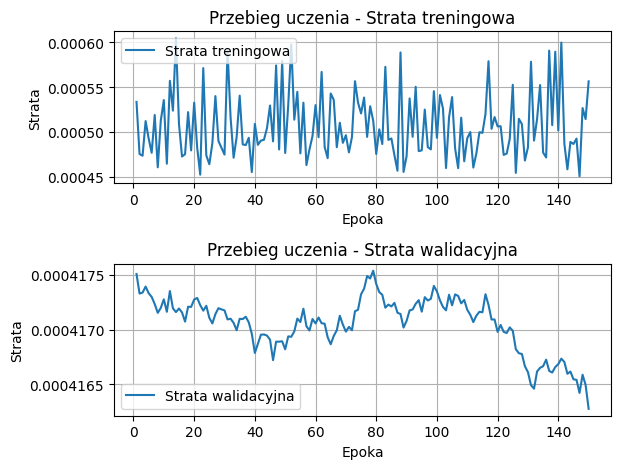

In [6]:
t_loss = [epoch_info.train_loss for epoch_info in epoch_info]
v_loss = [epoch_info.val_loss for epoch_info in epoch_info]
tl = t_loss[1:]
vl = v_loss[1:]

fig, axs = plt.subplots(2)

epochs = range(1, len(t_loss))
axs[0].plot(epochs, tl, label="Strata treningowa")
axs[1].plot(epochs, vl, label="Strata walidacyjna")
axs[0].set_xlabel("Epoka")
axs[0].set_ylabel("Strata")
axs[1].set_xlabel("Epoka")
axs[1].set_ylabel("Strata")
axs[0].set_title("Przebieg uczenia - Strata treningowa")
axs[1].set_title("Przebieg uczenia - Strata walidacyjna")
axs[0].legend()
axs[1].legend()
axs[0].grid(True)
axs[1].grid(True)
plt.tight_layout()
plt.show()

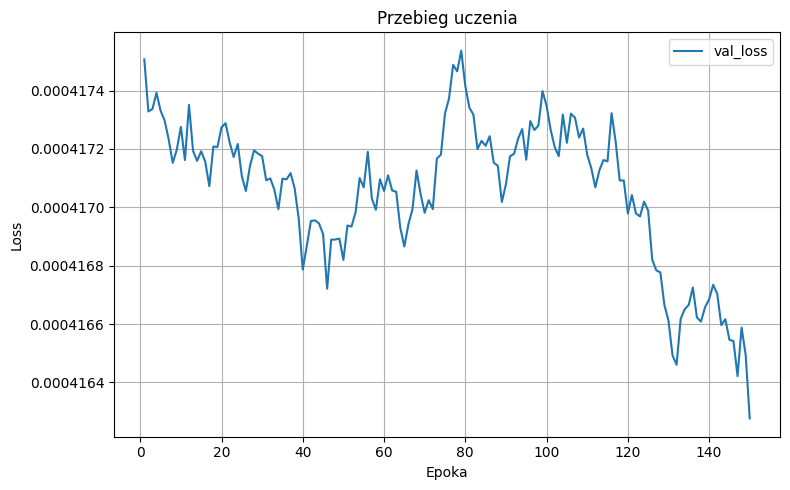

In [7]:
epochs = range(1, len(v_loss))
plt.figure(figsize=(8, 5))
plt.plot(epochs, vl, label="val_loss")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Przebieg uczenia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:


scores = important['svdd'].dists

scores_np = scores.cpu().numpy()

result = {
    my_test[idx].boot_id: float(scores_np[idx])
    for idx in np.argsort(scores_np)[::-1]   # descending
}

result_df = pd.DataFrame(result.items(), columns=['BootId', 'AnomalyScore'])
result_df.head(20)
result_df.to_csv(root_path + f'/Data/BSC/Results/BSC.csv', index=False)

In [46]:
def gini(x: np.ndarray) -> float:
    if x.size == 0:
        return float("nan")
    # musi być nieujemne
    x = x.astype(float)
    if np.any(x < 0):
        x = x - x.min()
    if np.all(x == 0):
        return 0.0

    x_sorted = np.sort(x)
    n = x_sorted.size
    cumx = np.cumsum(x_sorted)
    g = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return float(g)

mean_score = float(scores_np.mean())
std_score = float(scores_np.std())
cv = float(std_score / mean_score) if mean_score > 0 else float("nan")
spread = float(scores_np.max() - scores_np.min())
gini_coeff = gini(scores_np)

print(f"mean\t=\t{mean_score:.9f}\nstd\t=\t{std_score:.9f}\ncv\t=\t{cv:.9f}\nspread\t=\t{spread:.9f}\ngini\t=\t{gini_coeff:.6f}")

mean	=	0.000879931
std	=	0.000590422
cv	=	0.670986144
spread	=	0.002108262
gini	=	0.368152


In [47]:
df_labels = pd.read_csv(f"{root_path}/Data/BSC/anomaly_label.csv")
df_labels = df_labels.rename(columns={"BlockId": "BootId"})

merged = pd.merge(result_df, df_labels, on='BootId')

merged.shape

(37, 3)

Liczba próbek do ewaluacji: 37
Liczba anomalii: 16


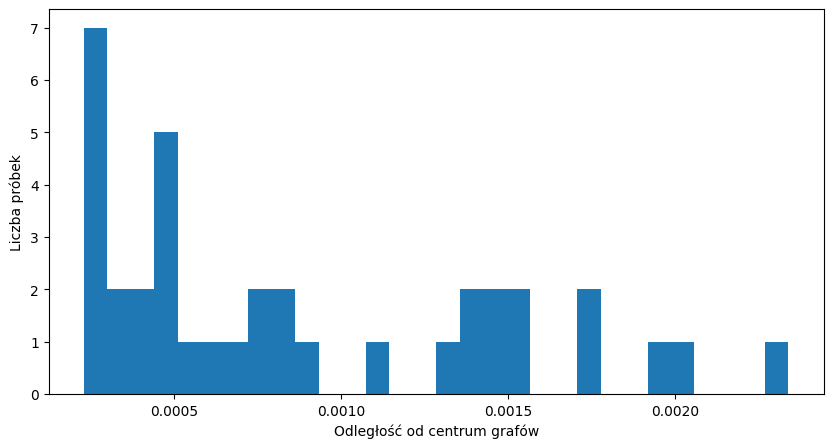

Best threshold = 0.00071250
==== METRYKI ====
Threshold           = 0.00071250
ROC-AUC             = 0.9821
Average Precision   = 0.9779   (PR-AUC)
Precision (thr)     = 0.8889
Recall (thr)        = 1.0000
F1-Score (thr)      = 0.9412


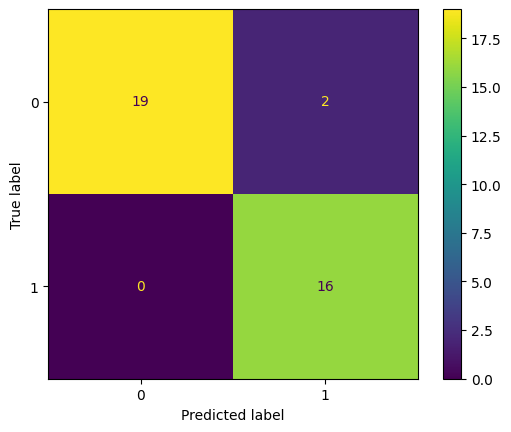


== Threshold = mean + 3σ (0.00147035) ==
F1        = 0.6667
Precision = 1.0000
Recall    = 0.5000
Confusion matrix:
 [[21  0]
 [ 8  8]]


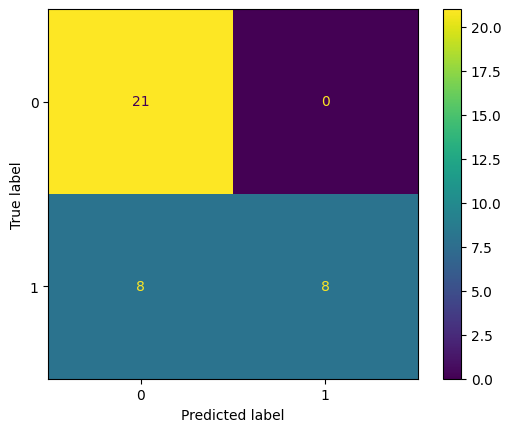

In [48]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df_labels = pd.read_csv(f"{root_path}/Data/BSC/anomaly_label.csv")
df_labels = df_labels.rename(columns={"BlockId": "BootId"})

merged = pd.merge(result_df, df_labels, on='BootId')

y_true = merged['Label'].apply(lambda x: 1 if x == 'Anomaly' else 0).values.astype(int)
y_score = merged["AnomalyScore"].values.astype(float)

print("Liczba próbek do ewaluacji:", len(y_true))
print("Liczba anomalii:", y_true.sum())

plt.figure(figsize=(10,5))
plt.hist(scores_np, bins=30)
plt.xlabel("Odległość od centrum grafów")
plt.ylabel("Liczba próbek")
plt.show()

num_thr = 500
thr_values = np.linspace(y_score.min(), y_score.max(), num_thr)

best_f1 = -1.0
best_thr = None
best_prec = None
best_rec = None
best_cm = None

for thr in thr_values:
    y_pred = (y_score > thr).astype(int)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
        best_prec = precision_score(y_true, y_pred, zero_division=0)
        best_rec = recall_score(y_true, y_pred, zero_division=0)
        best_cm = confusion_matrix(y_true, y_pred)

print(f"Best threshold = {best_thr:.8f}")


thr = best_thr

# Predykcje
y_pred = (y_score > thr).astype(int)

# Podstawowe metryki
roc_auc = roc_auc_score(y_true, y_score)
ap = average_precision_score(y_true, y_score)

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("==== METRYKI ====")
print(f"Threshold           = {thr:.8f}")
print(f"ROC-AUC             = {roc_auc:.4f}")
print(f"Average Precision   = {ap:.4f}   (PR-AUC)")
print(f"Precision (thr)     = {precision:.4f}")
print(f"Recall (thr)        = {recall:.4f}")
print(f"F1-Score (thr)      = {f1:.4f}")

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

mean = y_score.mean()
std = y_score.std()

thr_3s = mean + 1 * std
y_pred_3s = (y_score > thr_3s).astype(int)

f1_3s = f1_score(y_true, y_pred_3s, zero_division=0)
prec_3s = precision_score(y_true, y_pred_3s, zero_division=0)
rec_3s = recall_score(y_true, y_pred_3s, zero_division=0)
cm_3s = confusion_matrix(y_true, y_pred_3s)

print(f"\n== Threshold = mean + 3σ ({thr_3s:.8f}) ==")
print(f"F1        = {f1_3s:.4f}")
print(f"Precision = {prec_3s:.4f}")
print(f"Recall    = {rec_3s:.4f}")
print("Confusion matrix:\n", cm_3s)

disp = ConfusionMatrixDisplay(cm_3s)
disp.title = "Confusion Matrix (thr = mean + 3σ)"
disp.plot()
plt.show()

In [ ]:
t_loss = [epoch_info.train_loss for epoch_info in epoch_info]
v_loss = [epoch_info.val_loss for epoch_info in epoch_info]

print(len(v_loss[1:]))
print(len(t_loss[1:]))

150
150


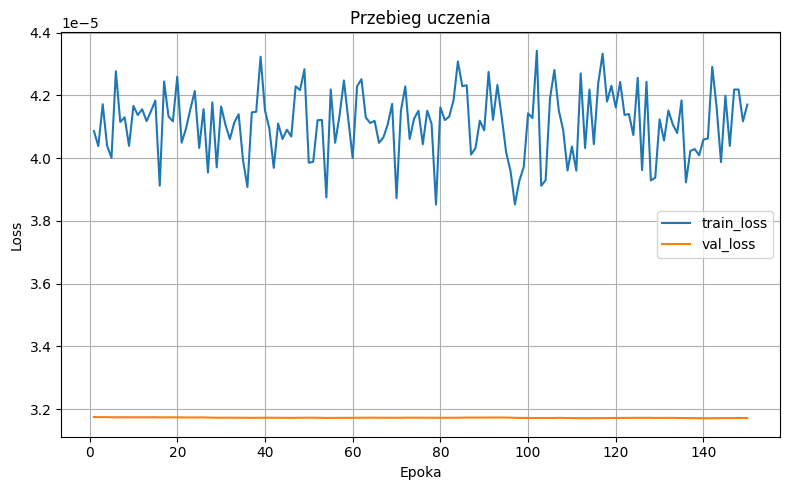

In [ ]:
t_loss = [epoch_info.train_loss for epoch_info in epoch_info]
v_loss = [epoch_info.val_loss for epoch_info in epoch_info]
tl = t_loss[1:]
vl = v_loss[1:]


epochs = range(1, len(t_loss))
plt.figure(figsize=(8, 5))
plt.plot(epochs, tl, label="train_loss")
plt.plot(epochs, vl, label="val_loss")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Przebieg uczenia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()